In [1]:
cd C:\Users\malkabir\OneDrive - University of New Mexico\All Personal Project\2020 M5 Forecasting Everything

C:\Users\malkabir\OneDrive - University of New Mexico\All Personal Project\2020 M5 Forecasting Everything


In [23]:
#standard
import pandas as pd, numpy as np
from numpy.random import randn

#stat

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic

#plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

#statistical method
from pylab import rcParams
import statsmodels.api as sm

import warnings
import itertools

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
%matplotlib inline

In [3]:
#read raw data
calendar=pd.read_csv("RawData/calendar.csv")
#read Raw sell_prices data
sell_prices=pd.read_csv("RawData/sell_prices.csv")
#Read sales_train_validation raw data
sales_train_validation=pd.read_csv("RawData/sales_train_validation.csv")

#make some copy
sell=sell_prices.copy()
cal=calendar.copy()
stv=sales_train_validation.copy()

In [12]:
# merge + fill NaNs
df_t = pd.merge(sales_long, calendar, how = 'left', on = ['d'])
df_t.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,unit_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [13]:
df_ti=df_t[['date','id','unit_sold']]
df_ti.head()

,date,id,unit_sold
0,2011-01-29,HOBBIES_1_001_CA_1_validation,0
1,2011-01-29,HOBBIES_1_002_CA_1_validation,0
2,2011-01-29,HOBBIES_1_003_CA_1_validation,0
3,2011-01-29,HOBBIES_1_004_CA_1_validation,0
4,2011-01-29,HOBBIES_1_005_CA_1_validation,0


In [14]:
df_ti.shape

(58327370, 3)

In [15]:
display(df_ti['unit_sold'].value_counts())

0      39777094
1       7753194
2       3894493
3       2098127
4       1279524
5        812653
6        565775
7        393514
8        300120
9        222644
10       178683
11       140168
12       121888
13        94337
14        79377
15        66900
16        57084
17        47969
18        41851
19        36027
20        32359
21        27965
22        24860
23        21980
24        21865
25        18099
26        16176
27        14571
28        13200
29        11763
         ...   
341           1
302           1
307           1
335           1
308           1
309           1
326           1
325           1
363           1
366           1
367           1
369           1
402           1
231           1
396           1
391           1
386           1
317           1
384           1
383           1
382           1
381           1
380           1
379           1
376           1
274           1
372           1
371           1
370           1
763           1
Name: unit_sold, Length:

In [17]:
df_tim=df_ti.set_index('date')
df_tim.head()

,id,unit_sold
date,,
2011-01-29,HOBBIES_1_001_CA_1_validation,0
2011-01-29,HOBBIES_1_002_CA_1_validation,0
2011-01-29,HOBBIES_1_003_CA_1_validation,0
2011-01-29,HOBBIES_1_004_CA_1_validation,0
2011-01-29,HOBBIES_1_005_CA_1_validation,0


In [38]:
df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'].head()

date
2011-01-29    0
2011-01-30    0
2011-01-31    0
2011-02-01    0
2011-02-02    0
Name: unit_sold, dtype: int64

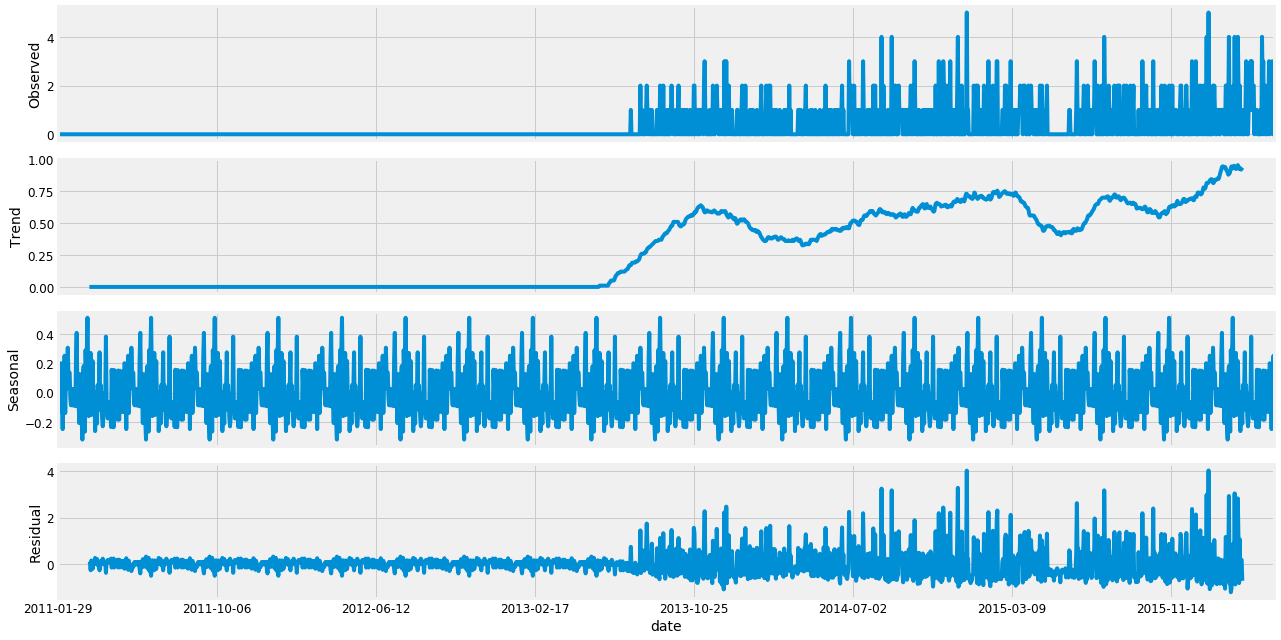

In [43]:
#Check the sesonality, trend and randomness of property price

rcParams['figure.figsize'] = 18, 9
decomposition = sm.tsa.seasonal_decompose(df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'], model='additive',freq=100)
fig = decomposition.plot()
plt.show()

In [24]:
#Choose best best_order, best_seasonal_order based on model aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_order = None
best_mdl = None
best_seasonal_order=None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'],order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            tmp_aic = results.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order=param
                best_seasonal_order=param_seasonal
                
        except:
            continue

print(f'ARIMA{best_order}x{best_order}12 - AIC:{best_aic}')

ARIMA(0, 1, 1)x(0, 1, 1)12 - AIC:3557.767922731344


In [27]:
#Arima model
mod = sm.tsa.statespace.SARIMAX(df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'],order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False).fit()

In [33]:
pred = mod.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [44]:
pred_ci.head()

,lower unit_sold,upper unit_sold
2016-01-01,-0.509676,1.918459
2016-01-02,-0.450423,1.977712
2016-01-03,-0.514738,1.913392
2016-01-04,-0.387946,2.040184
2016-01-05,-0.549889,1.878240


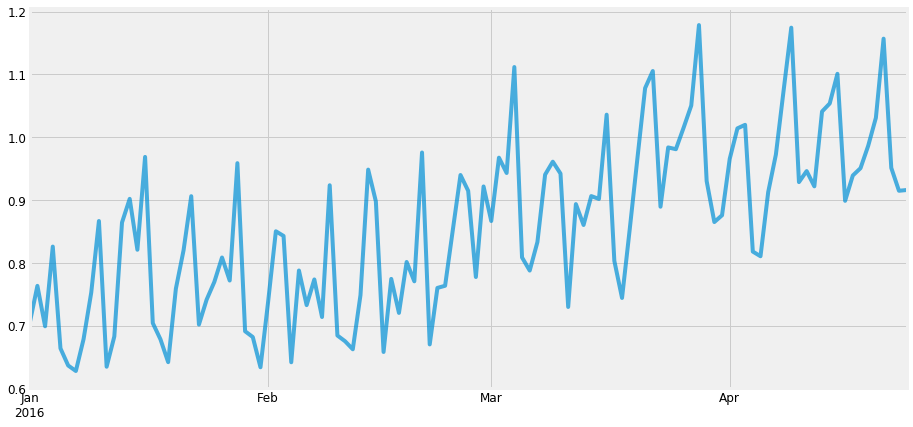

In [46]:
pred.predicted_mean.plot(label='Six-step ahead Forecast', alpha=.7, figsize=(14, 7))


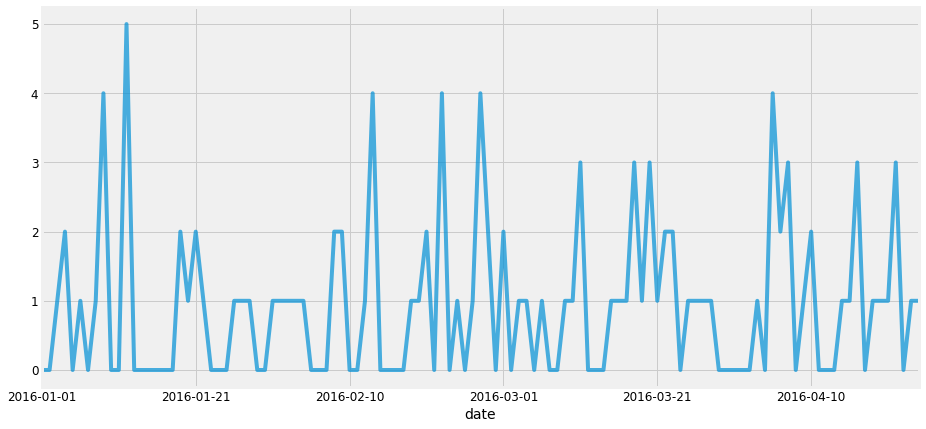

In [47]:
df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold']['2016-01-01':].plot(label='Six-step ahead Forecast', alpha=.7, figsize=(14, 7))

In [48]:
pred.predicted_mean.head()

2016-01-01    0.704391
2016-01-02    0.763644
2016-01-03    0.699327
2016-01-04    0.826119
2016-01-05    0.664176
Freq: D, dtype: float64

In [49]:
((pred.predicted_mean - df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold']['2016-01-01':]) ** 2).mean()

1.3032693532901223

In [60]:
def m5forecasting(walmartdata):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    best_aic = np.inf
    best_order = None
    best_mdl = None
    best_seasonal_order=None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(walmartdata,order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                tmp_aic = results.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order=param
                    best_seasonal_order=param_seasonal


                #print('ARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
            except:
                continue

    #print('ARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    mod = sm.tsa.statespace.SARIMAX(walmartdata,order=best_order,seasonal_order=best_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    return results.predict(alpha=0.05, start=1913, end=1969)

In [63]:
prediction=m5forecasting(df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'])

In [64]:
type(prediction)

pandas.core.series.Series

In [65]:
prediction.T

2016-04-25    0.999407
2016-04-26    0.994893
2016-04-27    0.994872
2016-04-28    0.985865
2016-04-29    0.999325
2016-04-30    0.994852
2016-05-01    0.994832
2016-05-02    0.994893
2016-05-03    0.985844
2016-05-04    0.999366
2016-05-05    0.994893
2016-05-06    0.994893
2016-05-07    0.994895
2016-05-08    0.994895
2016-05-09    0.994895
2016-05-10    0.994895
2016-05-11    0.994895
2016-05-12    0.994895
2016-05-13    0.994895
2016-05-14    0.994895
2016-05-15    0.994895
2016-05-16    0.994895
2016-05-17    0.994895
2016-05-18    0.994895
2016-05-19    0.994895
2016-05-20    0.994895
2016-05-21    0.994895
2016-05-22    0.994895
2016-05-23    0.994895
2016-05-24    0.994895
2016-05-25    0.994895
2016-05-26    0.994895
2016-05-27    0.994895
2016-05-28    0.994895
2016-05-29    0.994895
2016-05-30    0.994895
2016-05-31    0.994895
2016-06-01    0.994895
2016-06-02    0.994895
2016-06-03    0.994895
2016-06-04    0.994895
2016-06-05    0.994895
2016-06-06    0.994895
2016-06-07 

In [93]:
cnames=['id','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28']
df = pd.DataFrame(columns=cnames)

In [94]:
df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28


In [83]:
df['hello']=prediction.to_list()

In [96]:
for index,col in enumerate(df.columns):
    df.loc[0,col]=prediction.to_list()[index]

In [97]:
df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0.999407,0.994893,0.994872,0.985865,0.999325,0.994852,0.994832,0.994893,0.985844,0.999366,...,0.994895,0.994895,0.994895,0.994895,0.994895,0.994895,0.994895,0.994895,0.994895,0.994895


In [98]:
df_tim.head()

,id,unit_sold
date,,
2011-01-29,HOBBIES_1_001_CA_1_validation,0
2011-01-29,HOBBIES_1_002_CA_1_validation,0
2011-01-29,HOBBIES_1_003_CA_1_validation,0
2011-01-29,HOBBIES_1_004_CA_1_validation,0
2011-01-29,HOBBIES_1_005_CA_1_validation,0


In [101]:
df_tim.id.to_list()[0]

'HOBBIES_1_001_CA_1_validation'

In [102]:
cnames=['id','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28']
submission_df = pd.DataFrame(columns=cnames)

In [ ]:
for i in df_tim.id.to_list():
    for index,col in enumerate(submission_df.columns):
        df.loc[i,col]=m5forecasting(df_tim[df_tim['id']==i]['unit_sold']).to_list()[index]

In [ ]:
submission_df